In [1]:
import glob
import math
import os
import errno
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as ski
import re

from pathlib import Path
cur_dir = Path().resolve()
sys.path.append(str(cur_dir) + "/module")

In [2]:
img_path = r'C:\work\Pyhton\image\lena.png'
gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
rows, cols = gray_img.shape

## Filter
周波数領域の画像処理には、さまざまなフィルタリング手法が存在します。以下にいくつかの有用な周波数領域フィルタリング手法を挙げてみましょう。

1. **Wienerフィルター**: ノイズの存在する画像に適用されるフィルターで、画像の周波数特性とノイズの特性を利用して、ノイズを最小限に抑えつつ画像を復元します。

2. **Butterworthフィルター**: カットオフ周波数の近傍で滑らかな減衰を持つフィルターで、低周波や高周波成分を制御するために使用されます。

3. **Gaussianフィルター**: ガウス分布に基づくフィルターで、周波数領域での画像の平滑化を行います。周波数特性の中心から離れるほど減衰していく性質を持ちます。

4. **Homomorphicフィルター**: 画像の対数変換を行い、周波数領域での強度の正規化を行うことで、画像の光の照明条件による影響を軽減します。

5. **Notchフィルター**: 特定の周波数成分や周期的なノイズを除去するために使用されます。ノッチフィルターは、特定の周波数領域を除去または弱めることで、信号の特定の成分を除去します。

6. **Adaptiveフィルター**: 周波数領域での画像特性に基づいて、自動的にフィルタを調整する手法です。ローカルな画像の特性に合わせてフィルタを適応させることができます。

これらの手法は、画像の性質や処理目標に応じて選択されることがあります。周波数領域でのフィルタリングは、画像の情報を効果的に操作する手段の一つであり、画像処理の幅広いアプリケーションで利用されています。

In [3]:
# Lowpass filter
def lowpass_filter(fimg, cutoff_freq=30):
    rows, cols = fimg.shape
    center_y, center_x = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[center_y - cutoff_freq:center_y + cutoff_freq, center_x - cutoff_freq:center_x + cutoff_freq] = 1
    img_filterd = fimg * mask
    return img_filterd

# Highpass filter
def highpass_filter(fimg, cutoff_freq=30):
    rows, cols = fimg.shape
    center_y, center_x = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[center_y - cutoff_freq:center_y + cutoff_freq, center_x - cutoff_freq:center_x + cutoff_freq] = 0
    img_filtered = fimg * mask
    return img_filtered

# Bandpass filter
def bandpass_filter(fimg, low_cutoff_freq=10, high_cutoff_freq=50):
    rows, cols = fimg.shape
    center_y, center_x = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[center_y - high_cutoff_freq:center_y + high_cutoff_freq, center_x - high_cutoff_freq:center_x + high_cutoff_freq] = 1
    mask[center_y - low_cutoff_freq:center_y + low_cutoff_freq, center_x - low_cutoff_freq:center_x + low_cutoff_freq] = 0
    img_filtered = fimg * mask
    return img_filtered

# Wiener filter
def wiener_filter(fimg, kernel, noise_var):
    rows, cols = fimg.shape
    center_y, center_x = rows // 2, cols // 2
    f_kernel = np.fft.fft2(kernel, s=fimg.shape)
    mask = np.conj(f_kernel) / (np.abs(f_kernel) ** 2 + noise_var)
    img_filtered = fimg * mask
    return img_filtered

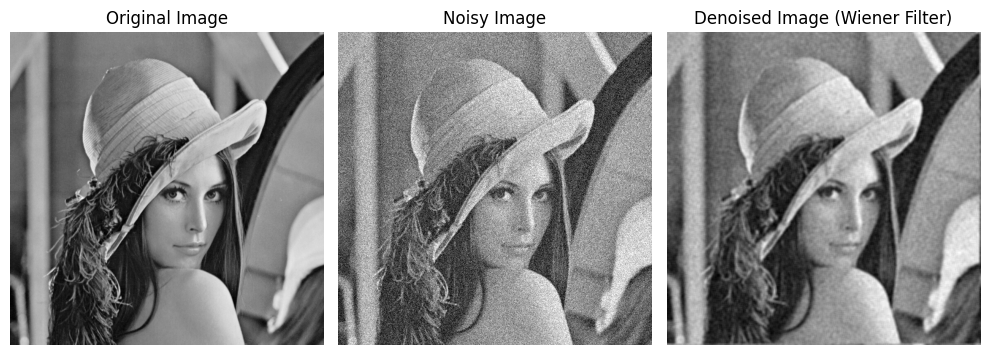

In [4]:
# Winerフィルタ
# 画像の読み込み
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# ノイズを生成して画像に加える
noise = np.random.normal(0, 25, image.shape)
noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

# Wienerフィルタを実装
def wiener_filter(input_image, kernel, noise_var):
    # フーリエ変換
    f_image = np.fft.fft2(input_image)
    f_kernel = np.fft.fft2(kernel, s=input_image.shape)
    
    # Wienerフィルタを計算
    filter = np.conj(f_kernel) / (np.abs(f_kernel) ** 2 + noise_var)
    filtered_image = np.fft.ifft2(f_image * filter).real
    
    return filtered_image

# カーネル（画像の特性を考慮して適切なカーネルを用意する必要があります）
kernel = np.ones((5, 5)) / 25

# ノイズの分散を推定（適切な値を設定）
estimated_noise_var = 80

# Wienerフィルタを適用
denoised_image = wiener_filter(noisy_image, kernel, estimated_noise_var)

# 画像を表示
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image (Wiener Filter)")
plt.axis('off')

plt.tight_layout()
plt.show()

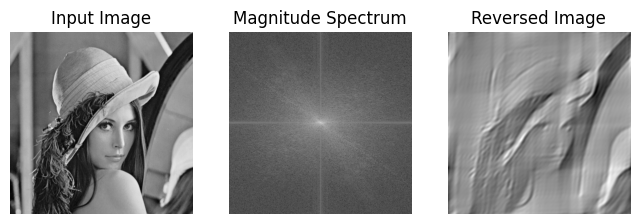

In [5]:
f_xy = np.asarray(gray_img)
f_uv = np.fft.fft2(f_xy)
# 第1象限ト第3象限、第2象限と第4象限を入れ替えて低周波成分を中心に集める
shifted_f_uv = np.fft.fftshift(f_uv)

# パワースペクトルに変換する
magnitude_spectrum2d = 20 * np.log10(np.abs(shifted_f_uv))

# 元の並びに直す
unshifted_f_uv = np.fft.fftshift(shifted_f_uv)
unshifted_f_uv = bandpass_filter(unshifted_f_uv, 200, 300)
# 2 次元逆高速フーリエ変換で空間領域の情報に戻す
i_f_xy = np.fft.ifft2(unshifted_f_uv).real  # 実数部だけ使う

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].imshow(f_xy, cmap='gray')
axes[0].set_title('Input Image')
axes[1].imshow(magnitude_spectrum2d, cmap='gray')
axes[1].set_title('Magnitude Spectrum')
axes[2].imshow(i_f_xy, cmap='gray')
axes[2].set_title('Reversed Image')
plt.show()

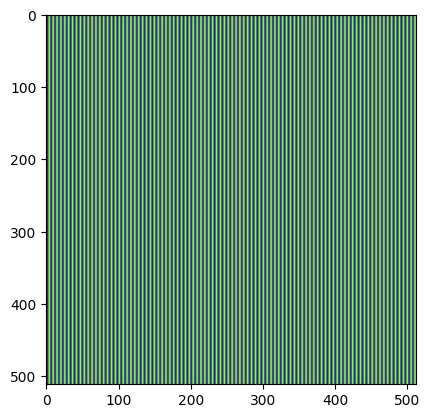

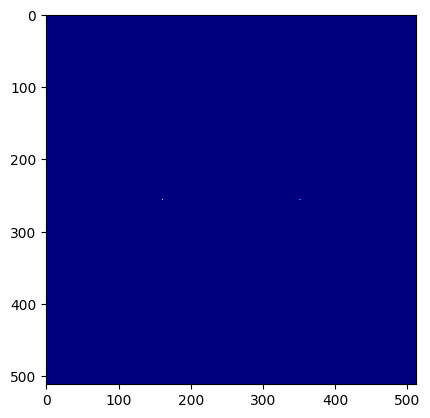

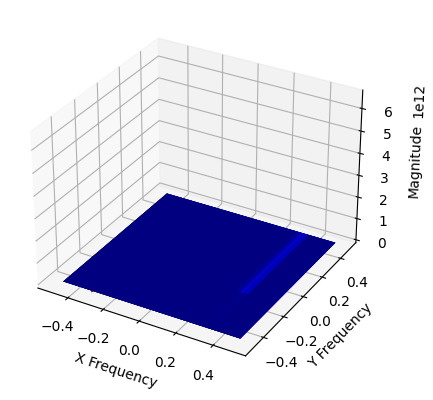

15.915494309189533
[[ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]
 [ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]
 [ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]
 ...
 [ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]
 [ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]
 [ 0.          0.00195312  0.00390625 ... -0.00585938 -0.00390625
  -0.00195312]]
Pixel at (256, 161) exceeds the threshold.
Pixel at (256, 351) exceeds the threshold.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 画像データを生成（サンプルとして正弦波を使用）
x = np.linspace(0, 1, 512)  # 0から1までの範囲で512点を生成
y = np.linspace(0, 1, 512)
X, Y = np.meshgrid(x, y)
# image_data = np.sin(20 * np.pi * X) + np.sin(10 * np.pi * Y)
image_data = 20*np.sin(1000000000*X)

fig, ax = plt.subplots()
ax.imshow(image_data)

# 2次元フーリエ変換を計算
fft_result = np.fft.fft2(image_data)
fft_result_shifted = np.fft.fftshift(fft_result)  # 結果をシフト（オプション）

# スペクトルの強度を取得
spectrum = np.abs(fft_result_shifted)*np.abs(fft_result_shifted)
# spectrum = 20*np.log10(np.abs(fft_result_shifted))

fig, ax = plt.subplots()
ax.imshow(spectrum, cmap='jet')

# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# スペクトルの座標軸を生成
x_freq = np.fft.fftfreq(image_data.shape[0])
y_freq = np.fft.fftfreq(image_data.shape[1])

X_freq, Y_freq = np.meshgrid(x_freq, y_freq)

# スペクトルを3Dでプロット
# ax.plot_surface(X_freq, Y_freq, spectrum, cmap='viridis')
ax.plot_surface(X_freq, Y_freq, spectrum, cmap='jet')

# ラベルを設定
ax.set_xlabel('X Frequency')
ax.set_ylabel('Y Frequency')
ax.set_zlabel('Magnitude')

# グラフを表示
plt.show()
print(50/np.pi)

# 閾値を設定（例: 0.5より大きいピクセル位置を取得）
threshold = np.max(spectrum) - 1

# 画像内の閾値を超えるピクセル位置を取得
rows, cols = np.where(spectrum > threshold)

# (rows, cols)には閾値を超えるピクセルの行列位置が格納される
print(X_freq)
# 結果を表示
for i in range(len(rows)):
    print(f"Pixel at ({rows[i]}, {cols[i]}) exceeds the threshold.")

```python
numpy.fft.fftfreq(n, d=1.0)
```

ここで、引数の意味は次の通りです：

n: データのサイズ（配列の要素数）を指定します。通常、2次元フーリエ変換を行う場合、画像の幅または高さのサイズがここに入ります。例えば、512x512の画像の場合、nは512になります。
d: サンプリング間隔を指定します。デフォルトでは1.0ですが、通常は1ピクセルあたりの距離を指定します。画像の場合、通常は1ピクセルあたりの距離が1です。
numpy.fft.fftfreq関数は、サイズnに対して、対応する周波数成分を計算し、それを配列として返します。返された配列は、DFTの結果である周波数成分に対応し、正の周波数と負の周波数の対称性を持っています。周波数成分は、ピクセルの逆数（サンプリング間隔dに対する逆数）を使って計算されます。したがって、周波数成分の単位は1/ピクセルまたは1/サンプリング間隔となります。

具体的な例を示すと、512x512の画像に対して、numpy.fft.fftfreq(512, 1.0)を呼び出すと、周波数成分を表す配列が得られ、その単位は1/ピクセルとなります。この配列は、各ピクセルの空間周波数成分を示します。

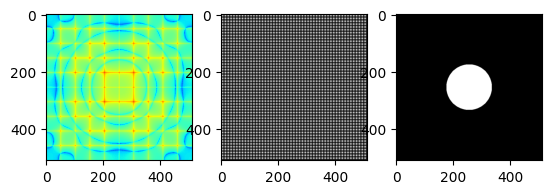

In [28]:
path = 'CH_sample.png'
# path = 'CH_sample_with_noise.png'
img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
fimg = np.fft.fft2(img)
fimg = np.fft.fftshift(fimg)
spectrum = 20*np.log10(abs(fimg))
rows, cols = img.shape
center = (rows//2, cols//2)
radius = 80
mask = np.zeros([rows, cols])
for i in range(rows):
    for j in range(cols):
        if (i - center[0])**2+(j - center[1])**2 < radius**2:
            mask[i][j] = 1
fimg_ = fimg*mask
fimg_ = np.fft.fftshift(fimg_)
inv = np.fft.ifft2(fimg_).real


fig, ax = plt.subplots(1, 3)
ax[0].imshow(spectrum, cmap='jet')
ax[1].imshow(inv, cmap='gray')
ax[2].imshow(mask, cmap='gray')
